In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook, we embark on a journey to understand the design philosophy of LLaMA 3.2 while implementing and testing its cutting-edge features. This will deepen our expertise in building and utilizing state-of-the-art large language models.

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import tiktoken

In [2]:
class Llama3(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.config = config
        self.token_emedding = nn.Embedding(
            config['vocab_size'], config['emb_dim'], dtype=config['dtype']
        )
                # Stack of transformer blocks, forming the core of the model
        self.tras_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layers'])]
        )
        # Final RMSNorm layer to normalize outputs of the transformer stack
        self.final_norm = nn.RMSNorm(config['emb_dim'])
        # Linear layer to project the hidden states back to the vocabulary size
        self.output = nn.Linear(
            config['emb_dim'], config['vocab_size'], bias=False, dtype=config['dtype']
        )

    def forward(self, x):
        # Token embedding: Convert input token indices to dense embeddings
        tok_emb = self.token_emedding(x)
        x = tok_emb
        # Pass through the stack of transformer blocks
        x = self.tras_blocks(tok_emb)
        # Normalize the output of the transformer stack
        x = self.final_norm(x)
        # Project the normalized output to the vocabulary space and return logits
        logits = self.output(x.to(torch.bfloat16))
        return logits


    

In [3]:
class RMSNorm(nn.Module):
    def __init__(self, config, eps=1e-5):
        super().__init__()
        # Store the configuration and epsilon value for numerical stability
        self.config = config
        self.eps = eps
        
        # Initialize the scale parameter (gamma), which will be learned during training
        # It has the same shape as the embedding dimension (config['emb_dim'])
        self.scale = nn.Parameter(torch.ones(config['emb_dim']))  

    def forward(self, x):
        # Compute the mean squared value of the input tensor across the last dimension
        # This is used to calculate the RMS (Root Mean Square) of each element in the input
        mean = x.pow(2).mean(dim=-1, keepdim=True)  # mean(x^2) along the last dimension
        
        # Normalize the input by dividing each element by the RMS of that element
        # torch.rsqrt computes the inverse square root (1/sqrt(x))
        x_norm = x * torch.rsqrt(mean + self.eps)  # Normalize using RMS
        
        # Apply the learnable scale parameter (gamma) to the normalized tensor
        # This scale parameter allows the model to learn the optimal scaling factor
        output = (self.scale * x_norm).to(dtype=x.dtype)  # Ensure the output has the same dtype as the input
        
        # Return the scaled and normalized tensor
        return output

In [4]:
# Define a sample configuration
config = {'emb_dim': 2048}

# Create a random input tensor
x = torch.randn(16, 32, config['emb_dim'])

# Create an instance of our custom RMSNorm
custom_rmsnorm = RMSNorm(config)
custom_output = custom_rmsnorm(x)

# Try PyTorch's RMSNorm implementation (if available)
try:
    from torch.nn import RMSNorm as TorchRMSNorm
    
    # Create an instance of PyTorch's RMSNorm
    torch_rmsnorm = TorchRMSNorm(config['emb_dim'], eps=1e-5)
    torch_output = torch_rmsnorm(x)
    
    # Compare the outputs (check if they are the same)
    outputs_are_equal = torch.allclose(custom_output, torch_output)
    print(f"Are the outputs equal? {outputs_are_equal}")
except ImportError:
    print("PyTorch RMSNorm is not available. Custom RMSNorm implementation is being used.")

Are the outputs equal? True


In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Initialize the multi-head attention layer
        self.att = GroupedQueryAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            num_kv_groups=config["n_kv_groups"],
            rope_base=config["rope_base"],
            rope_config=config["rope_freq"],
            dtype=config["dtype"]
        )
        # Initialize the feedforward layer
        self.ff = FeedForward(config)  # Assuming FeedForward is defined elsewhere
        # Initialize layer normalization layers
        self.norm1 = nn.RMSNorm(config['emb_dim'])  # First normalization layer
        self.norm2 = nn.RMSNorm(config['emb_dim'])  # Second normalization layer

    def forward(self, x):
        # Pass the input through the multi-head attention layer
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16))
        x = x + shortcut  # Residual connection
        
        # Pass the output through the feedforward layer
        shortcut = x  # Update shortcut after attention
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut  # Residual connection
        return x

1- FeedForward Layer with SiLU Activation
The FeedForward layer in a transformer block consists of two main components:

Linear Transformation: A fully connected layer that applies a linear transformation to the input tensor.
Non-linear Activation: After the linear transformation, a non-linear activation function is applied. In this case, we use SiLU (Sigmoid Linear Unit), which is a smooth and differentiable activation function that has shown strong performance in many deep learning models.
SiLU Activation:
SiLU, also known as the Swish activation function, is defined as:

[ \text{SiLU}(x) = x \cdot \sigma(x) ]

where ( \sigma(x) ) is the sigmoid function:

[ \sigma(x) = \frac{1}{1 + e^{-x}} ]

This activation is differentiable and allows for smooth gradients, making it particularly well-suited for deep networks.

In [7]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Initialize the first linear layer: Input -> Hidden layer
        self.fc1 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the second linear layer: Input -> Hidden layer (to be used in multiplication later)
        self.fc2 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the third linear layer: Hidden layer -> Output (back to original dimension)
        self.fc3 = nn.Linear(config['hidden_dim'], config['emb_dim'], bias=False)

    def forward(self, x):
        # Pass the input through the first linear layer
        x1 = self.fc1(x)
        
        # Pass the input through the second linear layer
        x2 = self.fc2(x)
        
        # Apply SiLU activation (Sigmoid Linear Unit) to the output of the first linear layer
        # Multiply the result with the output of the second linear layer
        # This operation introduces element-wise multiplication between activations and transformed values
        x = F.silu(x1) * x2 
        
        # Pass the result through the third linear layer to return to the original dimension
        x = self.fc3(x)
        
        return x

In [9]:
# Step 1: Define the sequence length and head dimension
# The sequence length represents the number of tokens (positions) in the sequence
# The head dimension represents the number of embedding dimensions for each token
sequence_length = 1024  # Length of the sequence (number of tokens)
head_dim = 64           # Dimension of each token's embedding vector
theta_base = 10000.0    # Base value used to calculate positional frequencies

# Step 2: Create the position tensor `m` representing the position of each token in the sequence
# `m` will have values from 0 to sequence_length - 1, representing the position of each token
# Mathematically, `m` is a vector {0, 1, 2, ..., sequence_length-1}
m = torch.arange(sequence_length).float()  # Positions in the sequence

# Step 3: Calculate the theta values using the formula from the Reformer paper
# We are calculating theta_i = 10000^(-2(i-1)/dim) for i = 1, 2, ..., head_dim/2
# The `theta_numerator` represents the indices i for every alternate value (i.e., 0, 2, 4, ..., head_dim-2)
theta_numerator = torch.arange(0, head_dim, 2).float()  # Indices for every alternate value
theta = 1.0 / (theta_base ** (theta_numerator / head_dim))  # Compute the theta values for each embedding dimension

# Step 4: Compute the outer product between `m` (positions) and `theta` (frequencies)
# The outer product between `m` and `theta` gives us a matrix where each element is the product of position and frequency
# Mathematically, freqs(i, j) = m_i * theta_j for each position i and dimension j
freqs = torch.outer(m, theta).float()  # Outer product between m and theta, resulting in positional frequencies

# Step 5: Convert the positional frequencies to complex numbers in polar form
# In polar form, a complex number is represented as R * exp(i * theta), where R = 1 (magnitude)
# We use `torch.polar` to create complex numbers with a magnitude of 1 and the computed frequencies as angles
freqs_complex = torch.polar(torch.ones_like(freqs), freqs)  # Convert frequencies to complex numbers (polar form)

# Now, `freqs_complex` contains the complex numbers representing the rotational encodings for each position
print(freqs_complex)

tensor([[ 1.0000+0.0000e+00j,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          ...,  1.0000+0.0000e+00j,  1.0000+0.0000e+00j,
          1.0000+0.0000e+00j],
        [ 0.5403+8.4147e-01j,  0.7318+6.8156e-01j,  0.8460+5.3317e-01j,
          ...,  1.0000+2.3714e-04j,  1.0000+1.7783e-04j,
          1.0000+1.3335e-04j],
        [-0.4161+9.0930e-01j,  0.0709+9.9748e-01j,  0.4315+9.0213e-01j,
          ...,  1.0000+4.7427e-04j,  1.0000+3.5566e-04j,
          1.0000+2.6670e-04j],
        ...,
        [-0.9998+1.7612e-02j,  0.6164-7.8744e-01j, -0.7242+6.8960e-01j,
          ...,  0.9708+2.3976e-01j,  0.9836+1.8057e-01j,
          0.9907+1.3573e-01j],
        [-0.5550-8.3182e-01j,  0.9877-1.5612e-01j, -0.9803+1.9732e-01j,
          ...,  0.9708+2.3999e-01j,  0.9835+1.8074e-01j,
          0.9907+1.3586e-01j],
        [ 0.4001-9.1649e-01j,  0.8292+5.5900e-01j, -0.9346-3.5578e-01j,
          ...,  0.9707+2.4022e-01j,  0.9835+1.8092e-01j,
          0.9907+1.3600e-01j]])


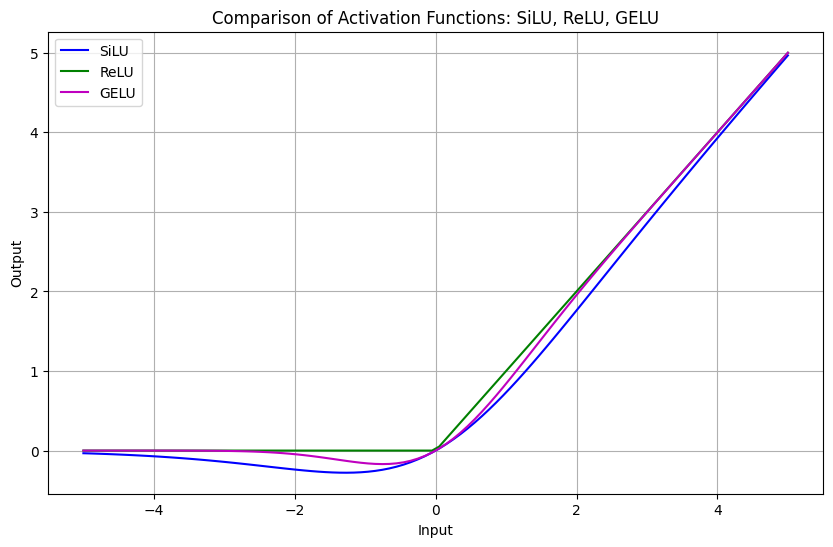

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Create input tensor
x = torch.linspace(-5, 5, steps=100)

# SiLU implementation from scratch
def silu(x):
    return x * torch.sigmoid(x)

# Calculate activations
silu_output = silu(x)
relu_output = F.relu(x)
gelu_output = F.gelu(x)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), silu_output.numpy(), label='SiLU', color='b')
plt.plot(x.numpy(), relu_output.numpy(), label='ReLU', color='g')
plt.plot(x.numpy(), gelu_output.numpy(), label='GELU', color='m')
plt.title('Comparison of Activation Functions: SiLU, ReLU, GELU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def apply_rotary_embeddings(x: torch.Tensor, freqs_complex: torch.Tensor, device: str):
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    freqs_complex = freqs_complex.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * freqs_complex
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

In [13]:
# THIS IS A COMPACT IMPLEMENTATION OF THE SAME CELL ABOVE 
def precompute_theta_pos_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    # As written in the paragraph 3.2.2 of the paper
    # >> In order to generalize our results in 2D to any xi ∈ Rd where **d is even**, [...]
    assert head_dim % 2 == 0, "Dimension must be divisible by 2"
    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device) # (Dim / 2)
    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)
    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs = torch.outer(m, theta).float()
    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_complex = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_complex

In [14]:
# Example input
batch_size = 4
seq_len = 10
head_dim = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate random input tensor (batch_size, seq_len, num_heads, head_dim)
x = torch.randn(batch_size, seq_len, 8, head_dim, device=device)

# Precompute frequency complex numbers
freqs_complex = precompute_theta_pos_frequencies(head_dim, seq_len, device)

# Apply rotary position embeddings
x_rot = apply_rotary_embeddings(x, freqs_complex, device)

print("Input shape:", x.shape)
print("Rotated shape:", x_rot.shape)   
print(x_rot[:5]) 

Input shape: torch.Size([4, 10, 8, 16])
Rotated shape: torch.Size([4, 10, 8, 16])
tensor([[[[ 0.4853,  0.0845, -0.8191,  ...,  0.0566, -1.6677,  0.0418],
          [-0.4706,  0.8150, -1.1517,  ..., -1.2831,  0.0746, -2.3797],
          [-0.0695,  0.9716,  2.6051,  ...,  0.2786, -0.0635,  1.1197],
          ...,
          [ 0.8343, -0.8970, -0.3091,  ..., -1.7149, -0.9758, -0.1683],
          [ 0.4093,  0.0781,  1.8028,  ..., -0.5999,  1.4788,  1.7273],
          [-2.2206,  0.5006, -0.9911,  ...,  0.3703, -0.0637, -0.7204]],

         [[ 0.2289,  1.5302,  0.9503,  ..., -0.4908,  0.7607,  2.0575],
          [ 1.3200, -0.7677, -3.3583,  ...,  0.6447,  0.2456,  0.7898],
          [ 0.5827,  1.0043,  0.3658,  ..., -0.5532, -0.4631,  0.4345],
          ...,
          [ 0.2650,  0.8098, -0.4660,  ..., -0.6597, -0.3532,  0.1453],
          [ 0.8254,  0.2598,  0.5432,  ..., -0.8409,  1.2401, -1.3810],
          [ 0.2830, -1.8397,  0.0167,  ...,  0.6197, -1.2532,  0.6989]],

         [[-1.4741, 

Grouped Query Attention (GQA)
Grouped Query Attention (GQA) is a variation of the standard Multi-Head Attention (MHA) mechanism used in transformer models. Instead of having multiple attention heads (as in MHA), GQA organizes queries into a smaller number of query groups, while the keys and values are not grouped. This approach reduces computational complexity while retaining expressive power.

Efficient RoPE

Key Components of GQA:
Query Grouping:

Queries are divided into groups, leading to fewer query computations compared to MHA.
Keys and values are not grouped, allowing them to attend to all input tokens.
Efficiency:

Reduces the memory and compute requirements of the attention mechanism compared to MHA.
Particularly advantageous for large models or when memory efficiency is critical.
Differences Between GQA and MHA:
Feature	Multi-Head Attention (MHA)	Grouped Query Attention (GQA)
Query Organization	Multiple independent attention heads	Queries are grouped into fewer groups
Key & Value Behavior	Separate keys and values for each attention head	Shared keys and values across query groups
Complexity	Higher due to multiple heads	Lower due to reduced number of query groups
Use Case	Suitable for tasks requiring high expressiveness	Suitable for memory-efficient scenarios
Practical Implication:
While MHA excels in providing diverse attention mechanisms across multiple heads, GQA trades off some of this flexibility to improve efficiency. It is commonly used in modern large-scale transformer architectures, like the LLaMA series, where scaling efficiency is critical without significantly compromising performance.

In [15]:
class SharedBuffers:
    # Dictionary to store precomputed buffers
    _buffers = {}

    @staticmethod
    def get_buffers(context_length, head_dim, rope_base, freq_config, dtype=torch.float32, device="cpu"):
        
        # Unique key based on the provided parameters to identify buffer configurations
        key = (
            context_length,
            head_dim,
            rope_base,
            tuple(freq_config.values()) if freq_config else freq_config,
            dtype
        )

        # Check if the buffers for this configuration already exist
        if key not in SharedBuffers._buffers:
            # If not, create the buffers

            # 1. Create a causal mask (upper triangular matrix)
            # Ensures future tokens do not attend to past tokens in the sequence
            mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)

            # 2. Compute RoPE frequencies using a custom precompute function
            # This function is assumed to generate complex frequencies for positional encoding
            freqs_complex = precompute_theta_pos_frequencies(
                head_dim, context_length, device, rope_base
            )

            # 3. Convert the RoPE frequencies to the desired data type if specified
            if dtype is not None:
                freqs_complex = freqs_complex.to(dtype)

            # 4. Cache the mask and frequencies in the shared dictionary
            SharedBuffers._buffers[key] = (mask, freqs_complex)

        # Return the cached or newly created buffers
        return SharedBuffers._buffers[key]

In [16]:
class GroupedQueryAttention(nn.Module):
    
    def __init__(
            self, d_in, d_out, context_length, num_heads,
            num_kv_groups, rope_base=10_000, rope_config=None,
            dtype=None, device='cpu'
        ):
        super().__init__()
        
        # Validations for divisibility constraints
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        # Initialization of key attributes
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Dimension per head
        self.device = device  # Store device for tensor operations

        # Linear transformations for keys, values, and queries
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)

        # Output projection layer for combining attention results
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)

        # Number of heads per group
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        # Fetch shared buffers for causal masks and RoPE frequencies
        mask, freqs_complex = SharedBuffers.get_buffers(
            context_length, self.head_dim, rope_base, rope_config, dtype=dtype, device=device
        )
        self.register_buffer("mask", mask)  # Cache causal mask as a buffer
        self.register_buffer("freqs_complex", freqs_complex)  # Cache RoPE frequencies as a buffer

    def forward(self, x):
        # x: Input tensor of shape (batch_size, num_tokens, d_in)
        b, num_tokens, d_in = x.shape

        # Compute keys, values, and queries
        queries = self.W_query(x)  # Shape: (b, num_tokens, d_out)
        keys = self.W_key(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)  # Shape: (b, num_tokens, num_kv_groups * head_dim)

        # Reshape keys, values, and queries for attention heads
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)

        # Transpose for compatibility with attention computation
        keys = keys.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        values = values.transpose(1, 2)  # Shape: (b, num_kv_groups, num_tokens, head_dim)
        queries = queries.transpose(1, 2)  # Shape: (b, num_heads, num_tokens, head_dim)

        # Apply rotary position encoding (RoPE) to keys and queries
        keys = apply_rotary_embeddings(keys, self.freqs_complex, self.device)
        queries = apply_rotary_embeddings(queries, self.freqs_complex, self.device)

        # Expand keys and values to match the number of heads
        keys = keys.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)
        values = values.repeat_interleave(self.group_size, dim=1)  # Shape: (b, num_heads, num_tokens, head_dim)

        # Compute scaled dot-product attention with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (b, num_heads, num_tokens, num_tokens)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Adjust mask size to current input length
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Apply causal mask

        # Normalize scores with softmax
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)  # Shape: (b, num_heads, num_tokens, num_tokens)

        # Compute attention output
        context_vec = (attn_weights @ values).transpose(1, 2)  # Shape: (b, num_tokens, num_heads, head_dim)

        # Combine attention heads into final output shape
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # Apply optional projection

        return context_vec

In [17]:
# Llama 3.2 1B

LLAMA32_CONFIG = {
    "vocab_size": 128_256,      # Vocabulary size
    "context_length": 131_072,  # Context length
    "emb_dim": 2048,            # Embedding dimension
    "n_heads": 32,              # Number of attention heads
    "n_layers": 16,             # Number of layers
    "hidden_dim": 8192,         # Size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,     # The base in RoPE's "theta"
    "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
    "rope_freq": {              # RoPE frequency scaling
        "factor": 32.0,
        "low_freq_factor": 1.0,
        "high_freq_factor": 4.0,
        "original_context_length": 8192,
    }
}

# Llama 3.2 3B

# LLAMA32_CONFIG = {
#     "vocab_size": 128_256,      # Vocabulary size
#     "context_length": 131_072,  # Context length
#     "emb_dim": 3072,            # Embedding dimension
#     "n_heads": 24,              # Number of attention heads
#     "n_layers": 28,             # Number of layers
#     "hidden_dim": 8192,         # Size of the intermediate dimension in FeedForward
#     "n_kv_groups": 8,           # Key-Value groups for grouped-query attention
#     "rope_base": 500_000.0,     # The base in RoPE's "theta"
#     "dtype": torch.bfloat16,    # Lower-precision dtype to reduce memory usage
#     "rope_freq": {              # RoPE frequency scaling
#         "factor": 32.0,
#         "low_freq_factor": 1.0,
#         "high_freq_factor": 4.0,
#         "original_context_length": 8192,
#     }
# }

LLAMA_SIZE_STR = "1B" if LLAMA32_CONFIG["emb_dim"] == 2048 else "3B"

In [18]:
old_context_length = LLAMA32_CONFIG["context_length"]
LLAMA32_CONFIG["context_length"] = 8192


def rescale_theta(theta_old, context_length_old, context_length_new):
    scaling_factor = context_length_new / context_length_old
    theta_new = theta_old * scaling_factor
    return theta_new

LLAMA32_CONFIG["rope_base"] = rescale_theta(
    LLAMA32_CONFIG["rope_base"],
    old_context_length,
    LLAMA32_CONFIG["context_length"]
)

print("New RoPE theta:", LLAMA32_CONFIG["rope_base"])

New RoPE theta: 31250.0


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [20]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Initialize the first linear layer: projects input embedding to hidden dimension
        self.fc1 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the second linear layer: creates additional projections for gating mechanism
        self.fc2 = nn.Linear(config['emb_dim'], config['hidden_dim'], bias=False)
        
        # Initialize the third linear layer: maps back from hidden dimension to original embedding dimension
        self.fc3 = nn.Linear(config['hidden_dim'], config['emb_dim'], bias=False)

    def forward(self, x):
        # Compute first projection
        x1 = self.fc1(x)
        # Compute second projection for gating
        x2 = self.fc2(x)
        # Element-wise multiplication after SiLU activation introduces non-linear interactions
        x = F.silu(x1) * x2 
        # Project back to the original embedding space
        x = self.fc3(x)
        return x


# GroupedQueryAttention Class
class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, context_length, num_heads,
            num_kv_groups, rope_base=10_000, rope_config=None,
            dtype=None, device='cpu'  # Device is specified with a default value
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        # Initialize essential parameters
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.device = device

        # Define linear layers for keys, values, and queries
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, bias=False, dtype=dtype)
        self.W_query = nn.Linear(d_in, d_out, bias=False, dtype=dtype)
        
        # Final projection layer after attention
        self.out_proj = nn.Linear(d_out, d_out, bias=False, dtype=dtype)

        # Configure the grouping structure for keys and values
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        # Shared buffers for causal mask and rotary embeddings
        mask, freqs_complex = SharedBuffers.get_buffers(
            context_length, self.head_dim, rope_base, rope_config, dtype=dtype, device=device
        )
        self.register_buffer("mask", mask)
        self.register_buffer("freqs_complex", freqs_complex)

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Compute queries, keys, and values
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # Reshape to support multi-head processing
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim)

        # Transpose for compatibility with attention computation
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # Apply rotary embeddings for positional information
        keys = apply_rotary_embeddings(keys, self.freqs_complex, self.device)
        queries = apply_rotary_embeddings(queries, self.freqs_complex, self.device)

        # Expand keys and values to align with query groups
        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        # Compute attention scores and apply causal mask
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # Normalize attention scores and compute weighted sum of values
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads and apply final projection
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec


# TransformerBlock Class
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Initialize multi-head attention layer
        self.att = GroupedQueryAttention(
            d_in=config["emb_dim"],
            d_out=config["emb_dim"],
            context_length=config["context_length"],
            num_heads=config["n_heads"],
            num_kv_groups=config["n_kv_groups"],
            rope_base=config["rope_base"],
            rope_config=config["rope_freq"],
            dtype=config["dtype"]
        )
        
        # Initialize feedforward network
        self.ff = FeedForward(config)
        
        # Layer normalization layers
        self.norm1 = nn.RMSNorm(config['emb_dim'])
        self.norm2 = nn.RMSNorm(config['emb_dim'])

    def forward(self, x):
        # Apply attention with residual connection
        shortcut = x
        x = self.norm1(x)
        x = self.att(x.to(torch.bfloat16))
        x = x + shortcut
        
        # Apply feedforward network with residual connection
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x.to(torch.bfloat16))
        x = x + shortcut
        return x


# Llama3 Class
class Llama3(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Token embedding layer to transform input tokens to dense vectors
        self.token_embedding = nn.Embedding(
            config['vocab_size'], config['emb_dim'], dtype=config['dtype']
        )
        
        # Stack of transformer blocks
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config['n_layers'])]
        )
        
        # Final layer normalization
        self.final_norm = nn.RMSNorm(config['emb_dim'])
        
        # Output projection to vocabulary size
        self.out_head = nn.Linear(
            config['emb_dim'], config['vocab_size'], bias=False, dtype=config['dtype']
        )

    def forward(self, x):
        # Convert token indices to embeddings
        tok_emb = self.token_embedding(x)
        x = tok_emb
        
        # Pass through transformer layers
        x = self.trf_blocks(tok_emb)
        
        # Normalize and project to logits
        x = self.final_norm(x)
        logits = self.out_head(x.to(torch.bfloat16))
        return logits

In [21]:
print(LLAMA32_CONFIG)
model = Llama3(LLAMA32_CONFIG)
print(model)

{'vocab_size': 128256, 'context_length': 8192, 'emb_dim': 2048, 'n_heads': 32, 'n_layers': 16, 'hidden_dim': 8192, 'n_kv_groups': 8, 'rope_base': 31250.0, 'dtype': torch.bfloat16, 'rope_freq': {'factor': 32.0, 'low_freq_factor': 1.0, 'high_freq_factor': 4.0, 'original_context_length': 8192}}


/tmp/ipykernel_36/3857862455.py:33: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:308.)
  freqs_complex = freqs_complex.to(dtype)


Llama3(
  (token_embedding): Embedding(128256, 2048)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_key): Linear(in_features=2048, out_features=512, bias=False)
        (W_value): Linear(in_features=2048, out_features=512, bias=False)
        (W_query): Linear(in_features=2048, out_features=2048, bias=False)
        (out_proj): Linear(in_features=2048, out_features=2048, bias=False)
      )
      (ff): FeedForward(
        (fc1): Linear(in_features=2048, out_features=8192, bias=False)
        (fc2): Linear(in_features=2048, out_features=8192, bias=False)
        (fc3): Linear(in_features=8192, out_features=2048, bias=False)
      )
      (norm1): RMSNorm((2048,), eps=None, elementwise_affine=True)
      (norm2): RMSNorm((2048,), eps=None, elementwise_affine=True)
    )
    (1): TransformerBlock(
      (att): GroupedQueryAttention(
        (W_key): Linear(in_features=2048, out_features=512, bias=False)
        (W_value): Linear(in_f

In [22]:
print(model.trf_blocks[0].att.mask is model.trf_blocks[-1].att.mask)
print(model.trf_blocks[0].att.freqs_complex is model.trf_blocks[-1].att.freqs_complex)

True
True


In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

# Account for weight tying
total_params_normalized = total_params - model.token_emedding.weight.numel()
print(f"\nTotal number of unique parameters: {total_params_normalized:,}")

Total number of parameters: 1,498,482,688


AttributeError: 'Llama3' object has no attribute 'token_emedding'

In [24]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 11.42 GB
bfloat16: 5.71 GB


In [25]:
# Importing necessary libraries
import os
from pathlib import Path

import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    def __init__(self, model_path):
        # Ensure that the provided model path is a valid file
        assert os.path.isfile(model_path), f"Model file {model_path} not found"
        
        # Load the mergeable ranks (Byte Pair Encoding) specific to the model
        mergeable_ranks = load_tiktoken_bpe(model_path)

        # Define special tokens for LLaMA3
        # These tokens help manage text boundaries, reserved spaces, and other control features in the text generation process
        self.special_tokens = {
            "<|begin_of_text|>": 128000,  # Token to signify the beginning of the text
            "<|end_of_text|>": 128001,    # Token to signify the end of the text
            "<|start_header_id|>": 128006,  # Token for starting a header section
            "<|end_header_id|>": 128007,   # Token for ending a header section
            "<|eot_id|>": 128009,         # Token for end-of-text (e.g., indicating the end of a content block)
        }
        
        # Additional reserved tokens for model-specific functionality (e.g., controlling certain operations)
        self.special_tokens.update({
            f"<|reserved_{i}|>": 128002 + i for i in range(256) if (128002 + i) not in self.special_tokens.values()
        })

        # Define the tokenization pattern
        # This regular expression is more complex compared to GPT-2 and captures more varied tokenization patterns
        # Handles contractions, special characters, and complex text formats like headers or sequences
        self.model = tiktoken.Encoding(
            name=Path(model_path).name,  # Use the name of the model file as the encoding name
            pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",  # Regex pattern for tokenization
            mergeable_ranks=mergeable_ranks,  # Load the BPE mergeable ranks specific to the model
            special_tokens=self.special_tokens  # Include special tokens defined earlier
        )


    def encode(self, text, bos=False, eos=False, allowed_special=set(), disallowed_special=()):
        """
        Encodes a given text input into tokens, optionally including special tokens like bos (beginning of sequence)
        and eos (end of sequence). The `allowed_special` and `disallowed_special` parameters allow for fine control 
        over which special tokens are included.
        """
        
        tokens = []

        # Optionally add the <|begin_of_text|> token if 'bos' is True (indicating the start of the sequence)
        if bos:
            tokens = [self.special_tokens["<|begin_of_text|>"]]

        # Use the tokenizer's `encode` method to tokenize the input text
        tokens += self.model.encode(text, allowed_special=allowed_special, disallowed_special=disallowed_special)

        # Optionally add the <|end_of_text|> token if 'eos' is True (indicating the end of the sequence)
        if eos:
            tokens.append(self.special_tokens["<|end_of_text|>"])

        return tokens

    def decode(self, tokens):
        """
        Decodes a sequence of tokens back into the original text.
        """
        return self.model.decode(tokens)

In [31]:
# Make sure you have an account to generate access token 
# make sure t have the right premission to access the repo from huggingface
from huggingface_hub import login

login()

In [28]:
!git config --global credential.helper store


In [29]:
!git lfs install


Git LFS initialized.


In [32]:
from huggingface_hub import hf_hub_download
LLAMA_SIZE_STR = "1B" if LLAMA32_CONFIG["emb_dim"] == 2048 else "3B"


tokenizer_file_path = hf_hub_download(
    repo_id=f"meta-llama/Llama-3.2-{LLAMA_SIZE_STR}-Instruct",
    filename="original/tokenizer.model",
    local_dir=f"Llama-3.2-{LLAMA_SIZE_STR}-Instruct"
)


GatedRepoError: 403 Client Error. (Request ID: Root=1-68bea1b6-759d7b2b4c9ac795365d9200;09abeb9d-79bb-4946-991a-084f46b944ed)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct/resolve/main/original/tokenizer.model.
Access to model meta-llama/Llama-3.2-1B-Instruct is restricted and you are not in the authorized list. Visit https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct to ask for access.